In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import random
import datetime
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
from random import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [37]:
data_train = pd.read_csv('train')
data_test = pd.read_csv('test')
pd.set_option('display.max_rows', data_train.shape[0]+1)
pd.set_option('display.max_columns', None)

### Data preprocessing

In [38]:
def oneHotCatVars(df, df_cols):
    
    df_1 = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))

def preprocess(df_):
    
    df = df_.copy()
    
    #missing value
    df = df.drop(df[df.od_number_of_similar_2_hours < 0].index)
    
    trip_or_dest = [f"{start}{end}"
         for start, end in zip( df.origin_station_name, df.destination_station_name)]
    df['trip_or_dest'] = trip_or_dest
    #df = df.assign(trip_or_dest = lambda data: trip_or_dest)
    
    trip_id = [f"{datetime}{time}{start}{end}"
       for datetime, time, start, end in zip(df.departure_date, df.od_origin_time, df.origin_station_name, df.destination_station_name)]
    df['trip_id'] = trip_id
    #df = df.assign(trip_id=lambda data:trip_id)
    
    sale_week = [datetime.date(year, month, day).isocalendar()[1]
                 for year, month, day in zip(df.sale_year, df.sale_month, df.sale_day)
                ]
    df['sale_week'] = sale_week
    
    df['revenu'] = df['price'] * df['demand']
    
    df['cum_demand'] = df.groupby(['trip_id'],sort=False).demand.cumsum()
    # Add new column: final_demand  =  as max(cum_bookings) for a given deparrture date  
    df['final_demand'] = df.groupby(['trip_id'], sort=False)['cum_demand'].transform(max) 
    # Add new colum: remaining_demand = final_demand - cum_bookings
    df['remaining_demand'] = df['final_demand'] - df['cum_demand']
    #Historical avg_booking_rates_demands for each day_prior (into) week_day combination     
    df['avg_remaining_demand'] = df.groupby(['sale_day_x'], sort=False)['remaining_demand'].transform(np.mean)  
    # Add new colum: booking_rate = cum_bookings / final_demand  
    df['booking_rate'] = df['cum_demand'] /df['final_demand']
    # Historical avg_booking_rates_demands for each day_prior (into) week_day combination     
    df['avg_booking_rate_weekday'] = df.groupby(['sale_day_x', 'sale_weekday'], sort=False)['booking_rate'].transform(np.mean)  
    # Historical avg_booking_rates_demands for each day_prior      
    df['avg_booking_rate'] = df.groupby(['sale_day_x'], sort=False)['booking_rate'].transform(np.mean)
    
    categorical_features_redondance = ['departure_date','sale_date','dataset_type','destination_station_name','origin_station_name']
    categorical_features_to_process = ['trip_or_dest']
    df = df.drop(columns=categorical_features_redondance)
    df = oneHotCatVars(df, categorical_features_to_process)
    
    
    df = df.join(
    df.groupby('trip_id')['price'].aggregate(['mean', 'min', 'max']),
    on='trip_id'
)

    
    # shift column 'Name' to first position
    first_column = df.pop('trip_id')
  
    # insert column using insert(position,column_name,
    # first_column) function
    df.insert(0, 'trip_id', first_column)
    
    # shift column 'Name' to first position
    second_column = df.pop('price')
  
    # insert column using insert(position,column_name,
    # first_column) function
    df.insert(1, 'price', second_column)
    return df


def split_data(df):
    
    
    X = df.drop(columns = ['trip_id','revenu','demand'])
    y= df['revenu']
    
    
    
    return X,y



In [39]:
data_train_ = preprocess(data_train)
data_test_ = preprocess(data_test)

In [40]:
X_train,y_train = split_data(data_train_)
X_test, y_test = split_data(data_test_)

In [7]:
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_test.shape, y_test.shape)

Training shapes: (632741, 43) (632741,)
Validation shapes: (32565, 43) (32565,)


### Model creation

### GridSearchCV params optimisation

In [8]:
def hyperParameterTuning(X_train_, y_train_):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }
    
    xgb_model = XGBRegressor()
    gsearch = GridSearchCV(estimator = xgb_model,
                       param_grid = param_tuning,                        
                       #scoring = 'neg_mean_absolute_error', #MAE
                       scoring = 'neg_mean_squared_error',  #MSE
                       cv = 2,
                       n_jobs = -1,
                       verbose = True)
    
    gsearch.fit(X_train_,y_train_)
        
    return gsearch.best_params_

In [9]:
X_t = X_train[:10000]
y_t = y_train[:10000]

In [10]:
X_t.shape

(10000, 43)

In [56]:
hyperParameterTuning(X_t, y_t)

Fitting 2 folds for each of 288 candidates, totalling 576 fits


KeyboardInterrupt: 

In [57]:
xgb_model_grid_optim = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.01,
        max_depth = 7,
        min_child_weight = 1,
        n_estimators = 500,
        subsample = 0.7)


In [58]:
xgb_model_grid_optim.fit(X_train, y_train,early_stopping_rounds=5, eval_set=[(X_train,y_train)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
y_pred_xgb = xgb_model_grid_optim.predict(X_test)

In [60]:
rmse = np.sqrt(MSE(y_test,y_pred_xgb))
print("RMSE : % f" %(rmse))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("MAE: ", mae_xgb)

RMSE :  127.654993
MAE:  56.57570715888849


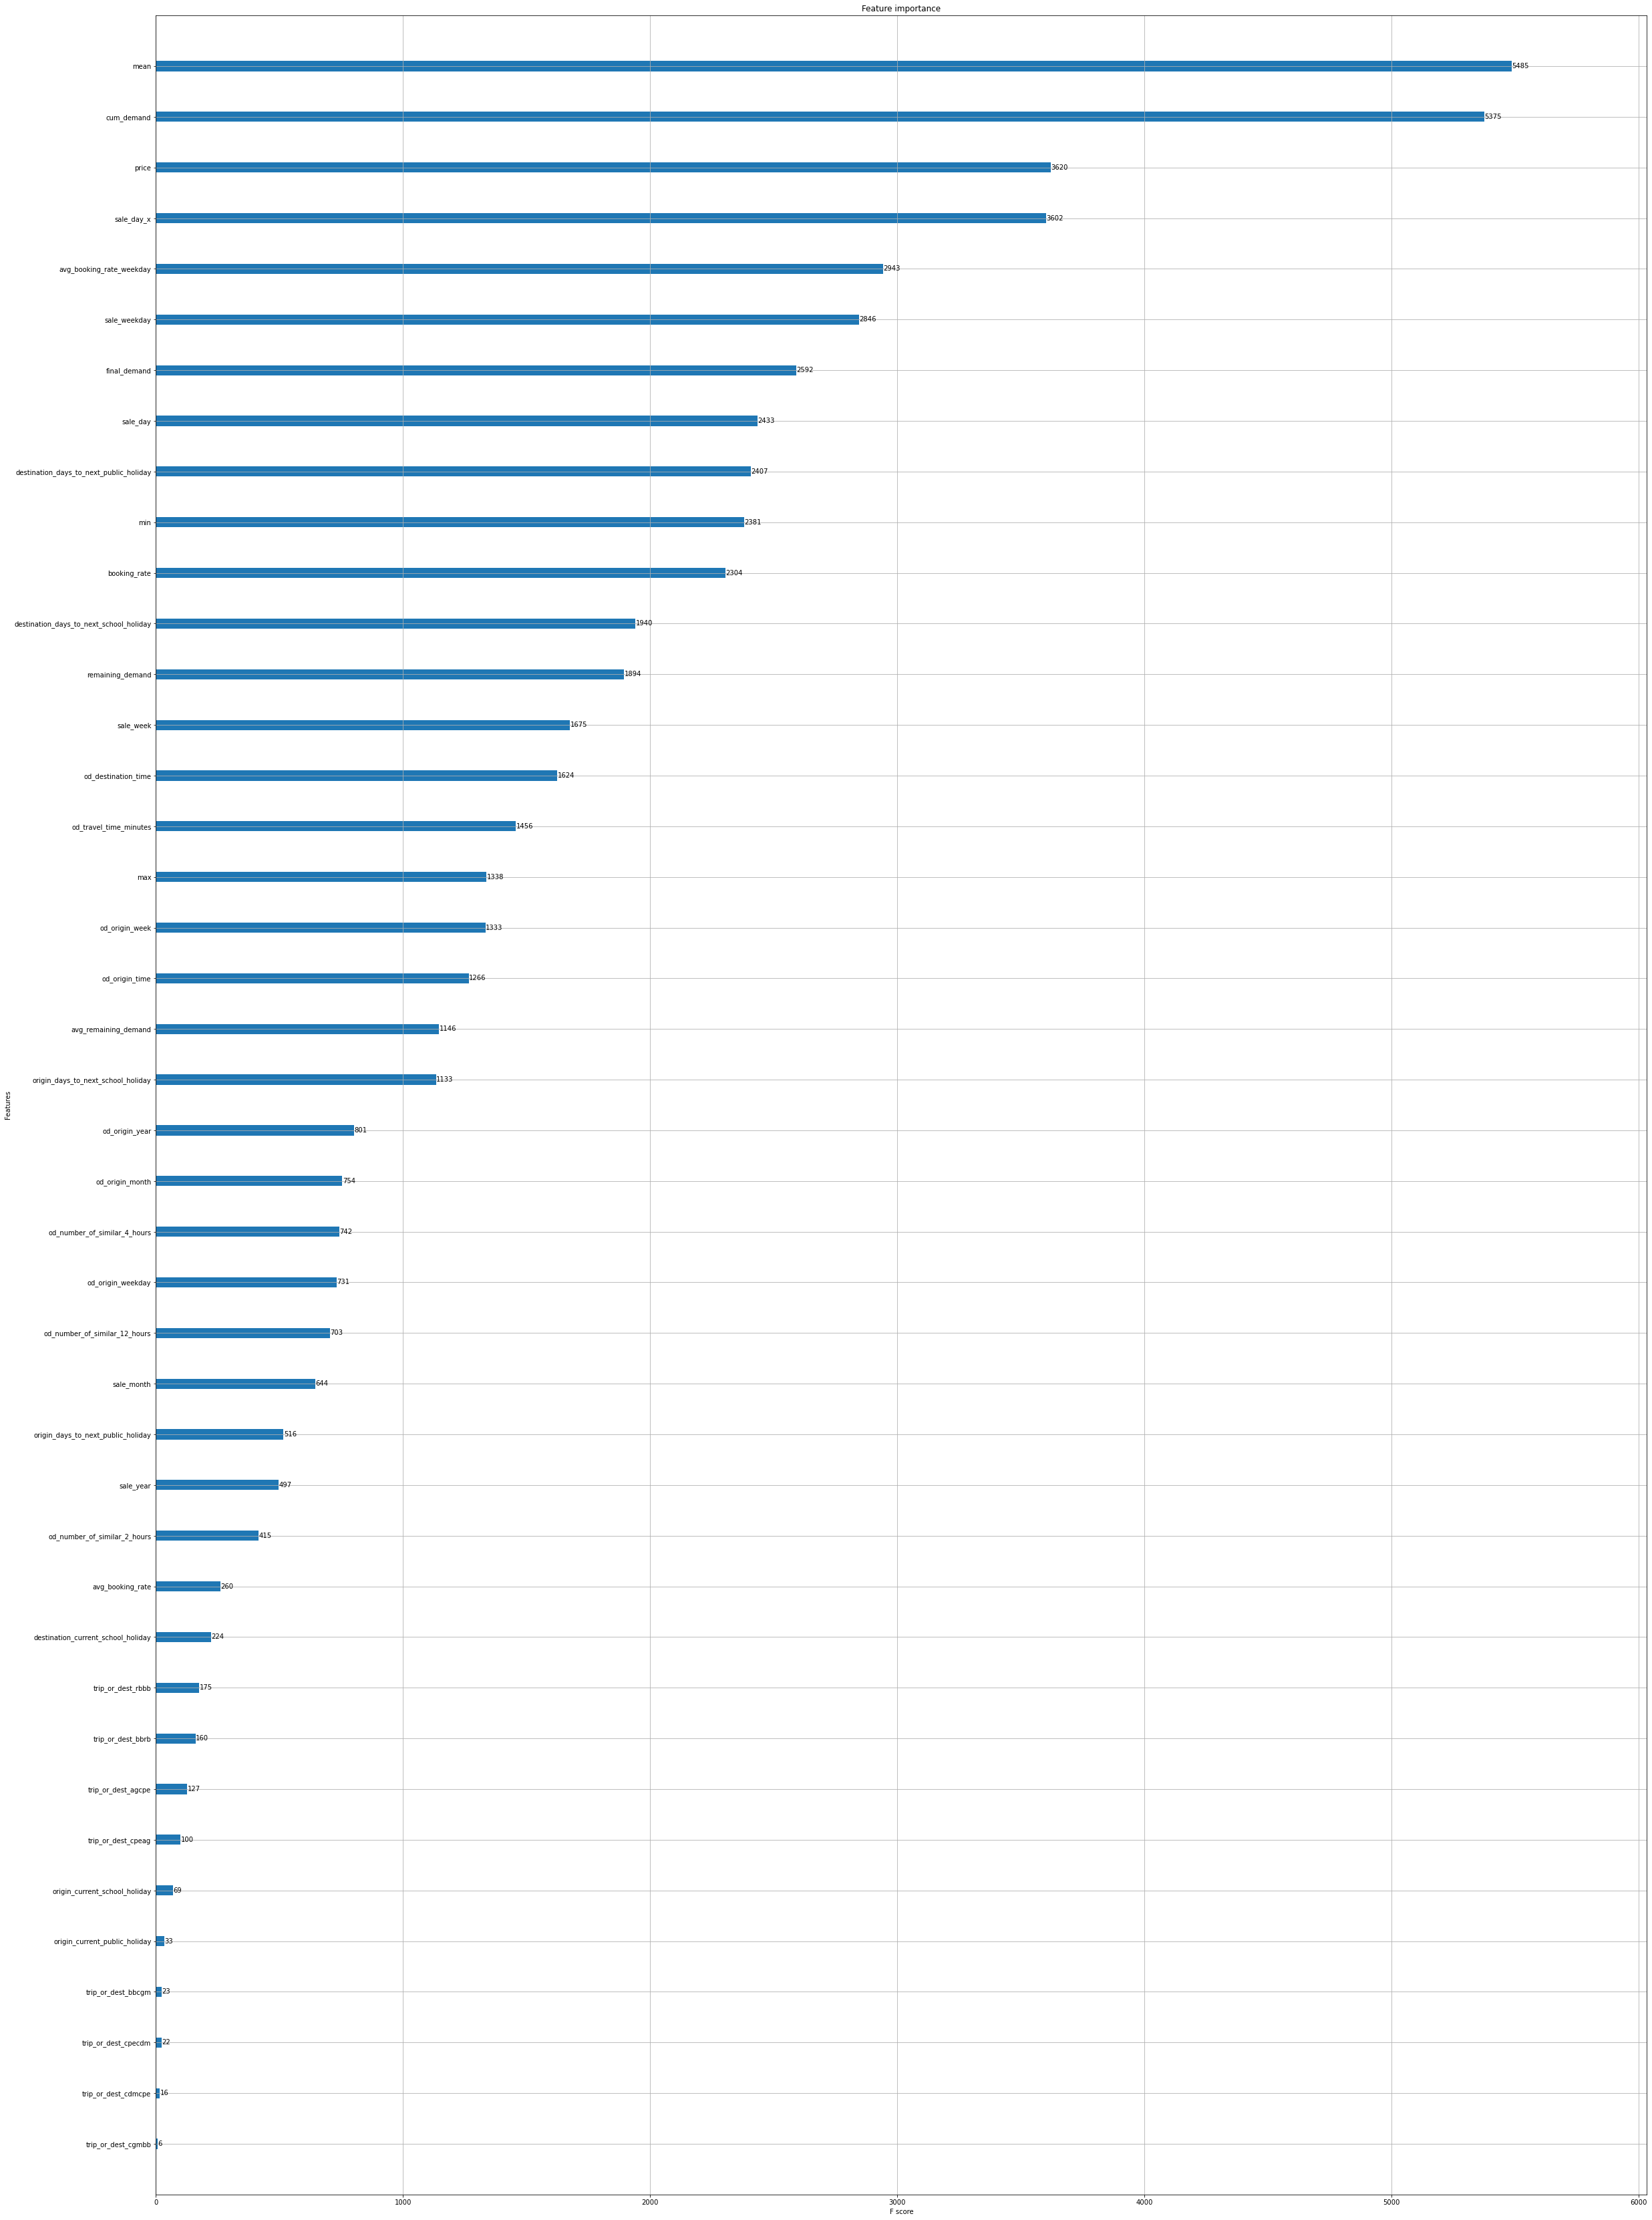

In [13]:
#plt.figure(figsize=(40,50))
fig, ax = plt.subplots(figsize=(40,60))
xgb.plot_importance(xgb_model_grid_optim, ax=ax)
plt.show()

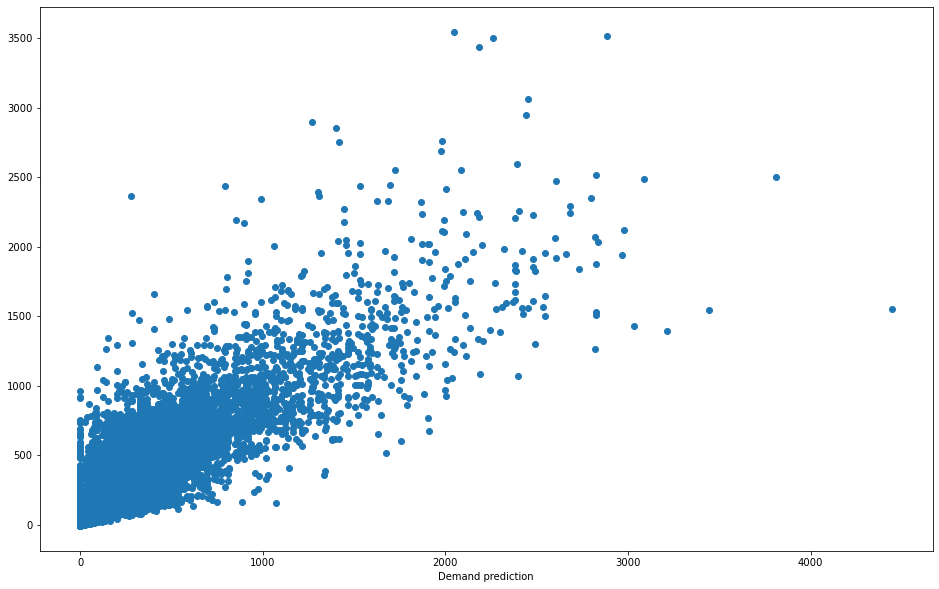

In [62]:
plt.figure(figsize=(16,10))
plt.scatter(y_test,xgb_model_grid_optim.predict(X_test) )
plt.xlabel("Real demand")
plt.xlabel("Demand prediction")
plt.show()

In [69]:
xgb_model.fit(X_train, y_train,early_stopping_rounds=5, eval_set=[(X_validation,y_valid)], verbose=False)
y_pred_xgb_validation = xgb_model.predict(X_validation)
rmse = np.sqrt(MSE(y_valid,y_pred_xgb_validation))
print("RMSE : % f" %(rmse))
mae_xgb = mean_absolute_error(y_valid, y_pred_xgb_validation)
print("MAE: ", mae_xgb)

RMSE :  2.869126
MAE:  1.2530283372889834


In [70]:
pred = xgb_model.predict(X_test)
rmse = np.sqrt(MSE(y_test,pred))
print("RMSE : % f" %(rmse))
mae_xgb = mean_absolute_error(y_test, pred)
print("MAE: ", mae_xgb)

RMSE :  4.001265
MAE:  1.9985212718731424


### Bayesian optimization tuning

In [15]:
space={
    'subsample': hp.uniform('subsample',0.5, 1),
    #"min_child_samples": hp.quniform("min_child_samples", 1,20,1),
    #'num_iterations': hp.quniform('num_iterations',100,200,20),
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    #'num_leaves': hp.quniform("num_leaves", 8, 128,10),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators' : hp.choice('n_estimators',[100, 200, 500]),
       'learning_rate': hp.uniform("learning_rate", 0.001, 0.1)
        
        
    }



def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = space['reg_alpha'],min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], learning_rate=space['learning_rate'], 
                         subsample = space['subsample'])
    
    evaluation = [( X_t, y_t), ( X_test, y_test)]
    
    model.fit(X_t, y_t,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

In [65]:
def objective(params):
    for param in set(["num_leaves","min_child_samples","max_depth",'num_iterations']):
        params[param] = int(params[param])
      
    
    kfold = KFold(3)
    score_test=[]
    for train_I, test_I in kfold.split(X_train):

        X_fold_train = X_train.iloc[train_I]
        y_fold_train = y_train.iloc[train_I]
        X_fold_test = X_train.iloc[test_I]
        y_fold_test = y_train.iloc[test_I]

        #On entraine un XGBRegressor avec les paramètres par défaut
        model = XGBRegressor()
        model.fit(X_fold_train, y_fold_train)

        #On calcule le score du modèle sur le test
        score_test.append(mean_absolute_error(y_fold_test, model.predict(X_fold_test)))
    return np.mean(score_test)
        
        


In [102]:
optim_params = optimizer(fn=xgboost_hyper_param, space=pbounds, algo=tpe.suggest, max_evals=90)

TypeError: 'BayesianOptimization' object is not callable

In [19]:
optim_params

{'colsample_bytree': 0.6000000000000001,
 'learning_rate': 0.08653855688102727,
 'max_depth': 12.0,
 'min_child_samples': 0.0,
 'n_estimators': 2,
 'num_iterations': 200.0,
 'num_leaves': 110.0,
 'reg_alpha': 3,
 'reg_lambda': 0,
 'subsample': 0.7566953986192881}

In [19]:
xgb_model_bayes_optim = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
    gamma = 5,
        learning_rate = 0.05,
        max_depth = 11,
        min_child_weight = 10,
        reg_alpha = 61,
    reg_lambda = 1,
        n_estimators = 500,
        subsample = 0.7)


In [21]:
xgb_model_bayes_optim.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=11,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=61, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
y_pred_xgb_test = xgb_model_bayes_optim.predict(X_test)
rmse = np.sqrt(MSE(y_test,y_pred_xgb_test))
print("RMSE : % f" %(rmse))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb_test)
print("MAE: ", mae_xgb)

RMSE :  137.123874
MAE:  61.93438350255723


In [30]:
data_test_['demand'] = (y_pred_xgb_test / data_test_['price']).astype(int)

In [31]:
X_test.head()

,price,destination_current_public_holiday,destination_current_school_holiday,destination_days_to_next_public_holiday,destination_days_to_next_school_holiday,od_destination_time,od_number_of_similar_12_hours,od_number_of_similar_2_hours,od_number_of_similar_4_hours,od_origin_month,od_origin_time,od_origin_week,od_origin_weekday,od_origin_year,od_travel_time_minutes,origin_current_public_holiday,origin_current_school_holiday,origin_days_to_next_public_holiday,origin_days_to_next_school_holiday,sale_day,sale_day_x,sale_month,sale_week,sale_weekday,sale_year,cum_demand,final_demand,remaining_demand,avg_remaining_demand,booking_rate,avg_booking_rate_weekday,avg_booking_rate,trip_or_dest_agcpe,trip_or_dest_bbcgm,trip_or_dest_bbrb,trip_or_dest_cdmcpe,trip_or_dest_cgmbb,trip_or_dest_cpeag,trip_or_dest_cpecdm,trip_or_dest_rbbb,mean,min,max,demand
0,20.65,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,19,-89,7,29,6,2020,0,485,485,280.516304,0.0,0.000546,0.000325,1,0,0,0,0,0,0,0,21.042857,20.65,26.65,0
1,20.65,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,20,-88,7,30,0,2020,0,485,485,280.385870,0.0,0.000856,0.000650,1,0,0,0,0,0,0,0,21.042857,20.65,26.65,0
2,20.65,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,21,-87,7,30,1,2020,0,485,485,281.016349,0.0,0.001487,0.001005,1,0,0,0,0,0,0,0,21.042857,20.65,26.65,0
3,20.65,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,22,-86,7,30,2,2020,0,485,485,285.865229,0.0,0.002090,0.001494,1,0,0,0,0,0,0,0,21.042857,20.65,26.65,0
4,20.65,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,23,-85,7,30,3,2020,0,485,485,290.810667,0.0,0.002747,0.001875,1,0,0,0,0,0,0,0,21.042857,20.65,26.65,0


### Validation du modèle

In [32]:
def pred_cumulative_demand_X(list_day_x, demand, X):
    
    somme = 0
    
    for v in range(len(list_day_x)-1, -1, -1):
        if list_day_x[v] >= X:
            somme += demand[v]        
        else:
            break
    return somme

In [107]:
def random_trip(data):
    
    trip_id = np.random.choice(data.trip_id.unique())
    
    
    return trip_id


def compute_pred_dem_cum(data, trip_id, model):
    remaining_demand_sale_x = {}
    res_trip_id = []
   
    trip_df = data.loc[(data['trip_id']==trip_id)]
    
    
    for sal_day_x, remaining_demand in zip(trip_df.sale_day_x, trip_df.remaining_demand):
        remaining_demand_sale_x[sal_day_x] = remaining_demand

    X_test,y_test = split_data(trip_df)
    days_val = [-90,-60,-30,-20,-15,-10,-7,-6,-5,-3,-2,-1]
    
    #demand_prediction = model.predict(X_test)
    revenue_prediction = model.predict(X_test)
    demand_prediction = list((revenue_prediction / X_test['price']).astype(int))
    list_sale_day_x = list(X_test.sale_day_x)
    
    for d in days_val:
        res_trip_id.append(pred_cumulative_demand_X(list_sale_day_x,demand_prediction,d))
        
    return res_trip_id, remaining_demand_sale_x
    

In [96]:
def compare_Y(remaining_demand_sale_x):
    days_vals = [-90,-60,-30,-20,-15,-10,-7,-6,-5,-3,-2,-1]
    y_test=[]
    for i in days_vals:
        if i in remaining_demand_sale_x:
            y_test.append(remaining_demand_sale_x[i])
        else:
            b=True
            while b:
                i+=1
                if i in remaining_demand_sale_x:
                    y_test.append(remaining_demand_sale_x[i])
                    b=False
                elif i==0:
                    y_test.append(0)
                    b=False
            
            
    return y_test

In [109]:
trip_id = random_trip(data_test_)


In [160]:
trip_id='2020-10-21534agcpe'





In [1]:
remaining_demand_sale_x_from_prediction, remaining_demand_sale_x_true = compute_pred_dem_cum(data_test_, trip_id, xgb_model_bayes_optim)

NameError: name 'compute_pred_dem_cum' is not defined

In [162]:
remaining_demand_sale_x_from_prediction

[626, 591, 475, 411, 358, 294, 237, 203, 203, 144, 108, 62]

In [163]:
y_test = compare_Y(remaining_demand_sale_x_true)
print(y_test)

[372, 365, 309, 264, 245, 202, 145, 129, 129, 73, 52, 0]


In [164]:
mae_xgb = mean_absolute_error(remaining_demand_sale_x_from_prediction, y_test)
print("MAE: ", mae_xgb)

MAE:  118.91666666666667


In [42]:
data_test_.head()

,trip_id,price,demand,destination_current_public_holiday,destination_current_school_holiday,destination_days_to_next_public_holiday,destination_days_to_next_school_holiday,od_destination_time,od_number_of_similar_12_hours,od_number_of_similar_2_hours,od_number_of_similar_4_hours,od_origin_month,od_origin_time,od_origin_week,od_origin_weekday,od_origin_year,od_travel_time_minutes,origin_current_public_holiday,origin_current_school_holiday,origin_days_to_next_public_holiday,origin_days_to_next_school_holiday,sale_day,sale_day_x,sale_month,sale_week,sale_weekday,sale_year,revenu,cum_demand,final_demand,remaining_demand,avg_remaining_demand,booking_rate,avg_booking_rate_weekday,avg_booking_rate,trip_or_dest_agcpe,trip_or_dest_bbcgm,trip_or_dest_bbrb,trip_or_dest_cdmcpe,trip_or_dest_cgmbb,trip_or_dest_cpeag,trip_or_dest_cpecdm,trip_or_dest_rbbb,mean,min,max
0,2020-10-16534agcpe,20.65,0,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,19,-89,7,29,6,2020,0.0,0,485,485,280.516304,0.0,0.000546,0.000325,1,0,0,0,0,0,0,0,21.042857,20.65,26.65
1,2020-10-16534agcpe,20.65,0,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,20,-88,7,30,0,2020,0.0,0,485,485,280.385870,0.0,0.000856,0.000650,1,0,0,0,0,0,0,0,21.042857,20.65,26.65
2,2020-10-16534agcpe,20.65,0,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,21,-87,7,30,1,2020,0.0,0,485,485,281.016349,0.0,0.001487,0.001005,1,0,0,0,0,0,0,0,21.042857,20.65,26.65
3,2020-10-16534agcpe,20.65,0,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,22,-86,7,30,2,2020,0.0,0,485,485,285.865229,0.0,0.002090,0.001494,1,0,0,0,0,0,0,0,21.042857,20.65,26.65
4,2020-10-16534agcpe,20.65,0,0,0,16,1,704,6,0,1,10,534,42,4,2020,170,0,1,16,1,23,-85,7,30,3,2020,0.0,0,485,485,290.810667,0.0,0.002747,0.001875,1,0,0,0,0,0,0,0,21.042857,20.65,26.65


In [167]:
trip_ids=['2020-10-17527cgmbb',
 '2020-10-19925cgmbb',
 '2020-10-28745cpecdm',
 '2020-10-261008agcpe',
 '2020-10-16938cgmbb',
 '2020-10-241008agcpe',
 '2020-10-191060bbrb',
 '2020-10-23925cgmbb',
 '2020-10-24745cpeag',
 '2020-10-16361bbcgm',
 '2020-10-261036cgmbb',
 '2020-10-26757rbbb',
 '2020-10-191184cpeag',
 '2020-10-171070cdmcpe',
 '2020-10-30534agcpe',
 '2020-10-241184cpeag',
 '2020-10-24745cpecdm',
 '2020-10-16938cgmbb',
 '2020-10-16852cdmcpe',
 '2020-10-16534agcpe',
 '2020-10-18576bbcgm',
 '2020-10-261238agcpe',
 '2020-10-231036cgmbb',
 '2020-10-18745cpeag',
 '2020-10-24508cgmbb',
 '2020-10-22532cpeag',
 '2020-10-28877rbbb',
 '2020-10-30669cgmbb',
 '2020-10-28852cdmcpe',
 '2020-10-201060bbcgm',
 '2020-10-22745cpeag',
 '2020-10-271184cpeag',
 '2020-10-27534agcpe',
 '2020-10-18527cgmbb',
 '2020-10-281060bbrb',
 '2020-10-22757rbbb',
 '2020-10-311008agcpe',
 '2020-10-20741agcpe',
 '2020-10-261036cgmbb',
 '2020-10-18785bbcgm',
 '2020-10-17669cgmbb',
 '2020-10-31532cpeag',
 '2020-10-26508cgmbb',
 '2020-10-171005bbcgm',
 '2020-10-23527cgmbb',
 '2020-10-23757rbbb',
 '2020-10-20925cgmbb',
 '2020-10-25532cpeag',
 '2020-10-18669cgmbb',
 '2020-10-251036cgmbb',
 '2020-10-18576bbcgm',
 '2020-10-281033rbbb',
 '2020-10-22877rbbb',
 '2020-10-171036cgmbb',
 '2020-10-18785bbrb',
 '2020-10-281184cpeag',
 '2020-10-201060bbrb',
 '2020-10-21527cgmbb',
 '2020-10-28360rbbb',
 '2020-10-24852cdmcpe',
 '2020-10-251036cgmbb',
 '2020-10-17532cpecdm',
 '2020-10-16925cgmbb',
 '2020-10-22877rbbb',
 '2020-10-301070cdmcpe',
 '2020-10-291036cgmbb',
 '2020-10-19925cgmbb',
 '2020-10-191060bbrb',
 '2020-10-241051cgmbb',
 '2020-10-22532cpeag',
 '2020-10-26757rbbb',
 '2020-10-311036cgmbb',
 '2020-10-22532cpecdm',
 '2020-10-21534agcpe',
 '2020-10-27745cpeag',
 '2020-10-231182cpeag',
 '2020-10-31532cpecdm',
 '2020-10-29532cpecdm',
 '2020-10-19669cgmbb',
 '2020-10-271008agcpe',
 '2020-10-191184cpeag',
 '2020-10-171051cgmbb',
 '2020-10-19532cpeag',
 '2020-10-22785bbrb',
 '2020-10-31527cgmbb',
 '2020-10-26360rbbb',
 '2020-10-291060bbcgm',
 '2020-10-30361bbcgm',
 '2020-10-271005bbcgm',
 '2020-10-17361bbcgm',
 '2020-10-17877rbbb',
 '2020-10-191184cpeag',
 '2020-10-181008agcpe',
 '2020-10-201238agcpe',
 '2020-10-27785bbrb',
 '2020-10-28745cpeag',
 '2020-10-22508cgmbb',
 '2020-10-31877rbbb',
 '2020-10-171238agcpe',
 '2020-10-231008agcpe']

In [168]:
all_mae=[]
for trip in trip_ids:
    y_pred, remaining_demand_sale_x = compute_pred_dem_cum(data_test_, trip, xgb_model_bayes_optim)
    y_test = compare_Y(remaining_demand_sale_x)
    all_mae.append( mean_absolute_error(y_pred, y_test))

In [169]:
all_mae

[5.166666666666667,
 0.0,
 33.0,
 30.833333333333332,
 2.25,
 41.666666666666664,
 104.5,
 15.166666666666666,
 21.583333333333332,
 1.0,
 2.3333333333333335,
 57.916666666666664,
 87.83333333333333,
 25.166666666666668,
 28.416666666666668,
 19.5,
 30.25,
 2.25,
 10.916666666666666,
 69.58333333333333,
 0.9166666666666666,
 42.083333333333336,
 0.0,
 61.833333333333336,
 2.6666666666666665,
 77.5,
 41.333333333333336,
 3.75,
 21.75,
 7.083333333333333,
 91.75,
 78.91666666666667,
 26.0,
 0.75,
 65.91666666666667,
 56.0,
 33.916666666666664,
 43.25,
 2.3333333333333335,
 0.0,
 1.1666666666666667,
 55.5,
 4.333333333333333,
 6.333333333333333,
 2.1666666666666665,
 54.333333333333336,
 1.4166666666666667,
 55.416666666666664,
 1.0833333333333333,
 0.0,
 0.9166666666666666,
 47.916666666666664,
 60.416666666666664,
 0.0,
 62.833333333333336,
 85.25,
 117.58333333333333,
 2.5,
 31.416666666666668,
 34.25,
 0.0,
 22.416666666666668,
 4.0,
 60.416666666666664,
 60.666666666666664,
 1.583333

In [170]:
np.mean(all_mae)

35.60916666666667

In [166]:
li=[0.9166666666666666,
 65.83333333333333,
 73.25,
 46.916666666666664,
 2.8333333333333335,
 2.5833333333333335,
 94.33333333333333,
 2.6666666666666665,
 34.666666666666664,
 78.83333333333333,
 0.5833333333333334,
 42.25,
 105.0,
 54.666666666666664,
 135.91666666666666,
 24.25,
 2.8333333333333335,
 0.75,
 69.0,
 30.5,
 0.6666666666666666,
 3.4166666666666665,
 5.166666666666667,
 0.5,
 2.1666666666666665,
 1.4166666666666667,
 34.75,
 16.0,
 78.75,
 1.0,
 0.5,
 0.08333333333333333,
 97.08333333333333,
 42.75,
 42.25,
 4.166666666666667,
 70.83333333333333,
 1.75,
 58.5,
 118.66666666666667,
 32.916666666666664,
 0.5,
 96.16666666666667,
 26.25,
 44.166666666666664,
 1.4166666666666667,
 0.8333333333333334,
 10.083333333333334,
 82.75,
 4.583333333333333]

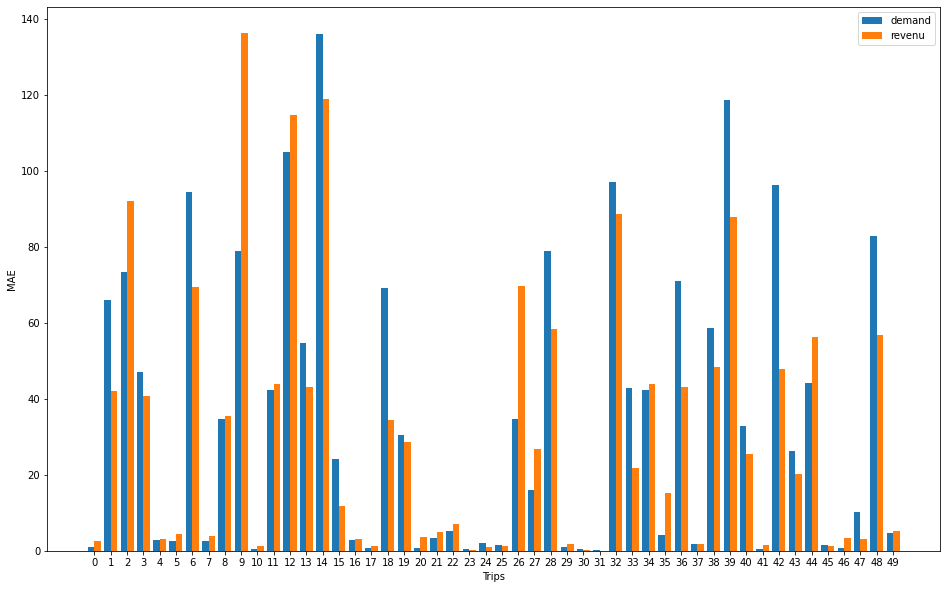

In [165]:
plt.figure(figsize=(16,10))
X_axis = np.arange(50)
  
plt.bar(X_axis - 0.2, li, 0.4, label = 'demand')
plt.bar(X_axis + 0.2, all_mae, 0.4, label = 'revenu')
  
plt.xticks(X_axis )
plt.xlabel("Trips")
plt.ylabel("MAE")

plt.legend()
plt.show()